In [0]:
# from engine.py import engine
# from engine import train_one_epoch, evaluate
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import os
import os.path
from os import path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import gzip
import tarfile
import gc
import cv2
import scipy.misc
from PIL import Image
from IPython.core.ultratb import AutoFormattedTB
from sklearn.metrics import confusion_matrix
import pandas as pd
import zipfile
from google.colab import drive

__ITB__ = AutoFormattedTB(mode = 'Plain',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
data_path = "/content/drive/My Drive/data/"
vision_path = "{}vision/references/detection/".format(data_path)
img_dir = '/tmp/ar_data/'

In [0]:
# Mount drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
if not path.exists(img_dir):
    # Unzip the ar_tag images, and write them to current
    zip_ref = zipfile.ZipFile("{}ar_data.zip".format(data_path), 'r')
    zip_ref.extractall("/tmp")
    zip_ref.close()

In [0]:
# function for showing imgs
def show_img(img_dir, name):
    img = cv2.imread('{}{}'.format(img_dir, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [0]:
# helper for combining pos and neg example csv's
def combine_pos_neg_csv(data_path, pos_filename, neg_filename, combined_filename):
    # open csv's
    pos_data = pd.read_csv('{}{}'.format(data_path, pos_filename))
    neg_data = pd.read_csv('{}{}'.format(data_path, neg_filename))
    print(pos_data.head())
    print(neg_data.head())
    # combine csv data
    data = pd.concat([pos_data, neg_data], ignore_index=True)
    # randomly shuffle
    print(data.head())
    data = data.sample(frac=1).reset_index(drop=True)
    data.reset_index(inplace=True)
    data.drop(columns=['index','Unnamed: 0'], inplace=True)
    print(data.head())
    # write to drive
    data.to_csv("{}{}".format(data_path, combined_filename))

In [0]:
# combine_pos_neg_csv(data_path, 'pos_ar_labels.csv', 'neg_ar_labels.csv', 'ar_labels.csv')

In [0]:
def write_train_test_split(data_path, file, frac):
    # open file as csv
    data = pd.read_csv('{}{}'.format(data_path, file))
    data.drop(columns=['Unnamed: 0'], inplace=True)
    # split into train and test sets
    train_set = data.sample(frac=frac, random_state=0)
    train_set.reset_index(inplace=True, drop=True)
    test_set = data.drop(train_set.index)
    test_set.reset_index(inplace=True, drop=True)
    # train_set.drop(columns=['Unnamed: 0'], inplace=True)
    # test_set.drop(columns=['Unnamed: 0'], inplace=True)
    # write sets
    train_set.to_csv('{}train_{}'.format(data_path, file))
    test_set.to_csv('{}test_{}'.format(data_path, file))

In [0]:
# write_train_test_split(data_path, 'ar_labels.csv', 0.75)

In [0]:
# Read in data
df = pd.read_csv('{}ar_labels.csv'.format(data_path))
train_df = pd.read_csv('{}train_ar_labels.csv'.format(data_path))
test_df = pd.read_csv('{}test_ar_labels.csv'.format(data_path))

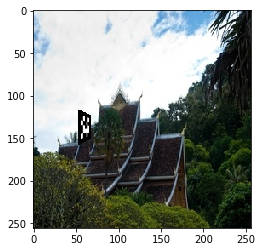

Unnamed: 0                                    1012
name          2ce383c0f9f810607bd1a7291eaefe50.jpg
valid                                            1
x                                               60
y                                              137
h                                               40
w                                               14
Name: 1012, dtype: object


In [0]:
show_img(img_dir, train_df.iloc[1012]['name'])
print(train_df.iloc[1012])

# AR Tag Dataset

In [0]:

class ARTagDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def get_corners(self, params):
        x_c = params[0]
        y_c = params[1]
        h = params[2]
        w = params[3]

        x1 = x_c - int(w/2)
        x2 = x_c + int(w/2)
        y1 = y_c - int(h/2)
        y2 = y_c + int(h/2)

        return [x1,y1,x2,y2]

    # returns tensor of [class,x1,y1,x2,y2]
    def get_corner_targs(self, idx):
        target = self.get_corners(self.df.iloc[idx][3:])
        label = self.df.iloc[idx][2]
        target.insert(0, label)

        return torch.as_tensor(target, dtype=torch.float32)

    # returns array of [class,x_center,y_center,h,w]
    def get_hw_targs(self, idx):
        targets = torch.as_tensor(self.df.iloc[idx][2:], dtype=torch.float32)
        return targets

    # returns two dicts {labels:label},{boxes:[x1,y1,x2,y2]}
    def get_boxes_dicts(self, idx):
        lbl_dict = {}
        label = self.df.iloc[idx][2]
        lbl_dict["labels"] = torch.as_tensor(label, dtype=torch.float32)

        box_dict = {}
        boxes = self.get_corners(self.df.iloc[idx][3:])
        box_dict["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)

        return lbl_dict, box_dict

    # returns dict {labels:label,boxes:[x1,y1,x2,y2]}
    def get_boxes_dict(self, idx):
        target = {}
        label = self.df.iloc[idx][2]
        target["labels"] = torch.as_tensor(label, dtype=torch.float32)

        boxes = self.get_corners(self.df.iloc[idx][3:])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)

        print(target)

        return target

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.img_dir, self.df.iloc[idx]['name'])
        img = io.imread(img_name)

        # target = self.get_corner_targs(idx)
        target = self.get_hw_targs(idx)
        # print(target)
        # lbl_dict, box_dict = self.get_boxes_dicts(idx)
        # target = self.get_boxes_dict(idx)

        if self.transform:
            img = self.transform(img)

        return img, target

In [0]:
# Get datasets
trans = transforms.Compose([
    # you can add other transformations in this list
    # FROM DOCUMENTATION: The images have to be loaded in to a range of [0, 1] and 
    # then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_data = ARTagDataset('{}train_ar_labels.csv'.format(data_path), img_dir, transform=trans)
test_data = ARTagDataset('{}test_ar_labels.csv'.format(data_path), img_dir, transform=trans)

train_loader = DataLoader(train_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

# Configuration

In [0]:
cfg = {
    'num_classes': 2,
    'lr_steps': (280000, 360000, 400000),
    'max_iter': 400000,
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'min_dim': 300,
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [21, 45, 99, 153, 207, 261],
    'max_sizes': [45, 99, 153, 207, 261, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    'variance': [0.1, 0.2],
    'clip': True,
    'name': 'AR',
}

In [32]:
# instantiate model
ssd_net = build_ssd('train', num_classes=2)
net = ssd_net

# optimizer
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0, weight_decay=0)
# multibox loss
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, True)

net.train()
net.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

# Training Loop

In [35]:
n_epochs = 200
pad = nn.ConstantPad2d((0, 44, 0, 44), 0)
for epoch in range(n_epochs):
    loop = tqdm(total=len(train_loader), position=0, leave=False)
    for batch, (x, target) in enumerate(train_loader):
        # add zero padding to get image to size 300
        x = pad(x)
        x = x.cuda()
        target = target.cuda()
        # targets = targets.cuda()
        print('\nx', x.shape)
        print('\ntarget', target)
        # print('\nlbl_dict', lbl_dict)
        # print('\nbox_dict', box_dict)
        # 1. zero_grad
        optimizer.zero_grad()
        # 2. predict
        out = net(x)
        print('out', out.shape)
        # 3. compute loss
        loss_l, loss_c = criterion(out, target)
        loss = loss_l + loss_c
        # 4. compute gradient
        loss.backward()
        # 5. backpropagate
        optimizer.step()

        break

        # 6. bookkeeping


  0%|          | 0/4219 [00:00<?, ?it/s]


x torch.Size([8, 3, 300, 300])

target tensor([[  1., 130., 240.,   8.,   7.],
        [  1., 124.,  63.,  72.,  70.],
        [  1., 108., 235.,  40.,  30.],
        [  0.,   0.,   0.,   0.,   0.],
        [  1.,  53., 161.,  24.,  -2.],
        [  1.,  26., 125.,  32.,  24.],
        [  1., 174.,  73.,  88.,  81.],
        [  1., 248.,  34.,  16.,  12.]], device='cuda:0')


AttributeError: ignored

# box_utils.py

In [0]:
# -*- coding: utf-8 -*-
import torch


def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior


def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]


# Adapted from https://github.com/Hakuyume/chainer-ssd
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes


def log_sum_exp(x):
    """Utility function for computing log_sum_exp while determining
    This will be used to determine unaveraged confidence loss across
    all examples in a batch.
    Args:
        x (Variable(tensor)): conf_preds from conf layers
    """
    x_max = x.data.max()
    return torch.log(torch.sum(torch.exp(x-x_max), 1, keepdim=True)) + x_max


# Original author: Francisco Massa:
# https://github.com/fmassa/object-detection.torch
# Ported to PyTorch by Max deGroot (02/01/2017)
def nms(boxes, scores, overlap=0.5, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count


# detection.py

In [0]:
import torch
from torch.autograd import Function
# from ..box_utils import decode, nms
# from data import voc as cfg


class Detect(Function):
    """At test time, Detect is the final layer of SSD.  Decode location preds,
    apply non-maximum suppression to location predictions based on conf
    scores and threshold to a top_k number of output predictions for both
    confidence score and locations.
    """
    def __init__(self, num_classes, bkg_label, top_k, conf_thresh, nms_thresh):
        self.num_classes = num_classes
        self.background_label = bkg_label
        self.top_k = top_k
        # Parameters used in nms.
        self.nms_thresh = nms_thresh
        if nms_thresh <= 0:
            raise ValueError('nms_threshold must be non negative.')
        self.conf_thresh = conf_thresh
        self.variance = cfg['variance']

    def forward(self, loc_data, conf_data, prior_data):
        """
        Args:
            loc_data: (tensor) Loc preds from loc layers
                Shape: [batch,num_priors*4]
            conf_data: (tensor) Shape: Conf preds from conf layers
                Shape: [batch*num_priors,num_classes]
            prior_data: (tensor) Prior boxes and variances from priorbox layers
                Shape: [1,num_priors,4]
        """
        num = loc_data.size(0)  # batch size
        num_priors = prior_data.size(0)
        output = torch.zeros(num, self.num_classes, self.top_k, 5)
        conf_preds = conf_data.view(num, num_priors,
                                    self.num_classes).transpose(2, 1)

        # Decode predictions into bboxes.
        for i in range(num):
            decoded_boxes = decode(loc_data[i], prior_data, self.variance)
            # For each class, perform nms
            conf_scores = conf_preds[i].clone()

            for cl in range(1, self.num_classes):
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                scores = conf_scores[cl][c_mask]
                if scores.size(0) == 0:
                    continue
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # idx of highest scoring and non-overlapping boxes per class
                ids, count = nms(boxes, scores, self.nms_thresh, self.top_k)
                output[i, cl, :count] = \
                    torch.cat((scores[ids[:count]].unsqueeze(1),
                               boxes[ids[:count]]), 1)
        flt = output.contiguous().view(num, -1, 5)
        _, idx = flt[:, :, 0].sort(1, descending=True)
        _, rank = idx.sort(1)
        flt[(rank < self.top_k).unsqueeze(-1).expand_as(flt)].fill_(0)
        return output


# prior_box.py

In [0]:
from __future__ import division
from math import sqrt as sqrt
from itertools import product as product
import torch


class PriorBox(object):
    """Compute priorbox coordinates in center-offset form for each source
    feature map.
    """
    def __init__(self, cfg):
        super(PriorBox, self).__init__()
        self.image_size = cfg['min_dim']
        # number of priors for feature map location (either 4 or 6)
        self.num_priors = len(cfg['aspect_ratios'])
        self.variance = cfg['variance'] or [0.1]
        self.feature_maps = cfg['feature_maps']
        self.min_sizes = cfg['min_sizes']
        self.max_sizes = cfg['max_sizes']
        self.steps = cfg['steps']
        self.aspect_ratios = cfg['aspect_ratios']
        self.clip = cfg['clip']
        self.version = cfg['name']
        for v in self.variance:
            if v <= 0:
                raise ValueError('Variances must be greater than 0')

    def forward(self):
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]
                # unit center x,y
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # aspect_ratio: 1
                # rel size: min_size
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # aspect_ratio: 1
                # rel size: sqrt(s_k * s_(k+1))
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # rest of aspect ratios
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
        # back to torch land
        output = torch.Tensor(mean).view(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output


# multibox_loss.py

In [0]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from data import coco as cfg
# from ..box_utils import match, log_sum_exp


class MultiBoxLoss(nn.Module):
    """SSD Weighted Loss Function
    Compute Targets:
        1) Produce Confidence Target Indices by matching  ground truth boxes
           with (default) 'priorboxes' that have jaccard index > threshold parameter
           (default threshold: 0.5).
        2) Produce localization target by 'encoding' variance into offsets of ground
           truth boxes and their matched  'priorboxes'.
        3) Hard negative mining to filter the excessive number of negative examples
           that comes with using a large number of default bounding boxes.
           (default negative:positive ratio 3:1)
    Objective Loss:
        L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N
        Where, Lconf is the CrossEntropy Loss and Lloc is the SmoothL1 Loss
        weighted by α which is set to 1 by cross val.
        Args:
            c: class confidences,
            l: predicted boxes,
            g: ground truth boxes
            N: number of matched default boxes
        See: https://arxiv.org/pdf/1512.02325.pdf for more details.
    """

    def __init__(self, num_classes, overlap_thresh, prior_for_matching,
                 bkg_label, neg_mining, neg_pos, neg_overlap, encode_target,
                 use_gpu=True):
        super(MultiBoxLoss, self).__init__()
        self.use_gpu = use_gpu
        self.num_classes = num_classes
        self.threshold = overlap_thresh
        self.background_label = bkg_label
        self.encode_target = encode_target
        self.use_prior_for_matching = prior_for_matching
        self.do_neg_mining = neg_mining
        self.negpos_ratio = neg_pos
        self.neg_overlap = neg_overlap
        self.variance = cfg['variance']

    def forward(self, predictions, targets):
        """Multibox Loss
        Args:
            predictions (tuple): A tuple containing loc preds, conf preds,
            and prior boxes from SSD net.
                conf shape: torch.size(batch_size,num_priors,num_classes)
                loc shape: torch.size(batch_size,num_priors,4)
                priors shape: torch.size(num_priors,4)

            targets (tensor): Ground truth boxes and labels for a batch,
                shape: [batch_size,num_objs,5] (last idx is the label).
        """
        loc_data, conf_data, priors = predictions
        num = loc_data.size(0)
        priors = priors[:loc_data.size(1), :]
        num_priors = (priors.size(0))
        num_classes = self.num_classes

        # match priors (default boxes) and ground truth boxes
        loc_t = torch.Tensor(num, num_priors, 4)
        conf_t = torch.LongTensor(num, num_priors)
        for idx in range(num):
            truths = targets[idx][:, :-1].data
            labels = targets[idx][:, -1].data
            defaults = priors.data
            match(self.threshold, truths, defaults, self.variance, labels,
                  loc_t, conf_t, idx)
        if self.use_gpu:
            loc_t = loc_t.cuda()
            conf_t = conf_t.cuda()
        # wrap targets
        loc_t = Variable(loc_t, requires_grad=False)
        conf_t = Variable(conf_t, requires_grad=False)

        pos = conf_t > 0
        num_pos = pos.sum(dim=1, keepdim=True)

        # Localization Loss (Smooth L1)
        # Shape: [batch,num_priors,4]
        pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data)
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, size_average=False)

        # Compute max conf across batch for hard negative mining
        batch_conf = conf_data.view(-1, self.num_classes)
        loss_c = log_sum_exp(batch_conf) - batch_conf.gather(1, conf_t.view(-1, 1))

        # Hard Negative Mining
        loss_c[pos] = 0  # filter out pos boxes for now
        loss_c = loss_c.view(num, -1)
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        num_pos = pos.long().sum(1, keepdim=True)
        num_neg = torch.clamp(self.negpos_ratio*num_pos, max=pos.size(1)-1)
        neg = idx_rank < num_neg.expand_as(idx_rank)

        # Confidence Loss Including Positive and Negative Examples
        pos_idx = pos.unsqueeze(2).expand_as(conf_data)
        neg_idx = neg.unsqueeze(2).expand_as(conf_data)
        conf_p = conf_data[(pos_idx+neg_idx).gt(0)].view(-1, self.num_classes)
        targets_weighted = conf_t[(pos+neg).gt(0)]
        loss_c = F.cross_entropy(conf_p, targets_weighted, size_average=False)

        # Sum of losses: L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N

        N = num_pos.data.sum()
        loss_l /= N
        loss_c /= N
        return loss_l, loss_c


# L2norm.py

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.autograd import Variable
import torch.nn.init as init

class L2Norm(nn.Module):
    def __init__(self,n_channels, scale):
        super(L2Norm,self).__init__()
        self.n_channels = n_channels
        self.gamma = scale or None
        self.eps = 1e-10
        self.weight = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.weight,self.gamma)

    def forward(self, x):
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        #x /= norm
        x = torch.div(x,norm)
        out = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return out

# ssd.py

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# from layers import *
# from data import voc, coco
import os

class SSD(nn.Module):
    """Single Shot Multibox Architecture
    The network is composed of a base VGG network followed by the
    added multibox conv layers.  Each multibox layer branches into
        1) conv2d for class conf scores
        2) conv2d for localization predictions
        3) associated priorbox layer to produce default bounding
           boxes specific to the layer's feature map size.
    See: https://arxiv.org/pdf/1512.02325.pdf for more details.
    Args:
        phase: (string) Can be "test" or "train"
        size: input image size
        base: VGG16 layers for input, size of either 300 or 500
        extras: extra layers that feed to multibox loc and conf layers
        head: "multibox head" consists of loc and conf conv layers
    """

    def __init__(self, phase, size, base, extras, head, num_classes):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        # self.cfg = (coco, voc)[num_classes == 21]
        self.cfg = cfg
        self.priorbox = PriorBox(self.cfg)
        self.priors = Variable(self.priorbox.forward(), volatile=True)
        self.size = size

        # SSD network
        self.vgg = nn.ModuleList(base)
        # Layer learns to scale the l2 normalized features from conv4_3
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(extras)

        self.loc = nn.ModuleList(head[0])
        self.conf = nn.ModuleList(head[1])

        if phase == 'test':
            self.softmax = nn.Softmax(dim=-1)
            self.detect = Detect(num_classes, 0, 200, 0.01, 0.45)

    def forward(self, x):
        """Applies network layers and ops on input image(s) x.
        Args:
            x: input image or batch of images. Shape: [batch,3,300,300].
        Return:
            Depending on phase:
            test:
                Variable(tensor) of output class label predictions,
                confidence score, and corresponding location predictions for
                each object detected. Shape: [batch,topk,7]
            train:
                list of concat outputs from:
                    1: confidence layers, Shape: [batch*num_priors,num_classes]
                    2: localization layers, Shape: [batch,num_priors*4]
                    3: priorbox layers, Shape: [2,num_priors*4]
        """
        sources = list()
        loc = list()
        conf = list()

        # apply vgg up to conv4_3 relu
        for k in range(23):
            x = self.vgg[k](x)

        s = self.L2Norm(x)
        sources.append(s)

        # apply vgg up to fc7
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        sources.append(x)

        # apply extra layers and cache source layer outputs
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:
                sources.append(x)

        # apply multibox head to source layers
        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)
        if self.phase == "test":
            output = self.detect(
                loc.view(loc.size(0), -1, 4),                   # loc preds
                self.softmax(conf.view(conf.size(0), -1,
                             self.num_classes)),                # conf preds
                self.priors.type(type(x.data))                  # default boxes
            )
        else:
            output = (
                loc.view(loc.size(0), -1, 4),
                conf.view(conf.size(0), -1, self.num_classes),
                self.priors
            )
        return output

    def load_weights(self, base_file):
        other, ext = os.path.splitext(base_file)
        if ext == '.pkl' or '.pth':
            print('Loading weights into state dict...')
            self.load_state_dict(torch.load(base_file,
                                 map_location=lambda storage, loc: storage))
            print('Finished!')
        else:
            print('Sorry only .pth and .pkl files supported.')


# This function is derived from torchvision VGG make_layers()
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
def vgg(cfg, i, batch_norm=False):
    layers = []
    in_channels = i
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return layers


def add_extras(cfg, i, batch_norm=False):
    # Extra layers added to VGG for feature scaling
    layers = []
    in_channels = i
    flag = False
    for k, v in enumerate(cfg):
        if in_channels != 'S':
            if v == 'S':
                layers += [nn.Conv2d(in_channels, cfg[k + 1],
                           kernel_size=(1, 3)[flag], stride=2, padding=1)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=(1, 3)[flag])]
            flag = not flag
        in_channels = v
    return layers


def multibox(vgg, extra_layers, cfg, num_classes):
    loc_layers = []
    conf_layers = []
    vgg_source = [21, -2]
    for k, v in enumerate(vgg_source):
        loc_layers += [nn.Conv2d(vgg[v].out_channels,
                                 cfg[k] * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(vgg[v].out_channels,
                        cfg[k] * num_classes, kernel_size=3, padding=1)]
    for k, v in enumerate(extra_layers[1::2], 2):
        loc_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(v.out_channels, cfg[k]
                                  * num_classes, kernel_size=3, padding=1)]
    return vgg, extra_layers, (loc_layers, conf_layers)


base = {
    '300': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M',
            512, 512, 512],
    '512': [],
}
extras = {
    '300': [256, 'S', 512, 128, 'S', 256, 128, 256, 128, 256],
    '512': [],
}
mbox = {
    '300': [4, 6, 6, 6, 4, 4],  # number of boxes per feature map location
    '512': [],
}


def build_ssd(phase, size=300, num_classes=21):
    if phase != "test" and phase != "train":
        print("ERROR: Phase: " + phase + " not recognized")
        return
    if size != 300:
        print("ERROR: You specified size " + repr(size) + ". However, " +
              "currently only SSD300 (size=300) is supported!")
        return
    base_, extras_, head_ = multibox(vgg(base[str(size)], 3),
                                     add_extras(extras[str(size)], 1024),
                                     mbox[str(size)], num_classes)
    return SSD(phase, size, base_, extras_, head_, num_classes)